In [13]:
import mediapipe as mp
import pickle as pk
from tqdm import tqdm
import cv2
import os
import pickle
import time

import matplotlib.pyplot as plt

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from neural_net import NeuralNet
import torch

### Dataset

In [2]:
isl_dir = './data/asl_data/'
print(f'Number of signs included: {len(os.listdir(isl_dir))}')
isl_signs = os.listdir(isl_dir)
isl_signs.sort()
for d in isl_signs:
    if d == '.DS_Store':
        continue
    print(f'{d}: {len(os.listdir(os.path.join(isl_dir, d)))}')

Number of signs included: 30
A: 3000
B: 3000
C: 3000
D: 3000
E: 3000
F: 3000
G: 3000
H: 3000
I: 3000
J: 3000
K: 3000
L: 3000
M: 3000
N: 3000
O: 3000
P: 3000
Q: 3000
R: 3000
S: 3000
T: 3000
U: 3000
V: 3000
W: 3000
X: 3000
Y: 3000
Z: 3000
del: 3000
nothing: 3000
space: 3000


### Creating labelled dataset

In [3]:
# initializing image directory

DATA_DIR = './data/asl_data'
data_prefix = f'prep_data/{DATA_DIR.split("/")[-1]}'

In [4]:
# initiating mediapipe configurations

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

# 1-hand vs 2-hands signs
# signs_1_hand = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'C', 'I', 'L', 'O', 'U', 'V']
# signs_2_hand = ['A', 'B', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'W', 'X', 'Y', 'Z']

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
# data1 = []
# labels1 = []
# data2 = []
# labels2 = []
data = []
labels = []
max_count = 1000 # 20

for dir_ in tqdm(os.listdir(DATA_DIR)):
    if dir_ == '.DS_Store':
        continue
    count = 0
    for img_path in os.listdir(os.path.join(DATA_DIR, dir_)):
        data_aux = []
        img = cv2.imread(os.path.join(DATA_DIR, dir_, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        results = hands.process(img_rgb)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y
                    data_aux.append(x)
                    data_aux.append(y)
            # if len(data_aux) == 42 and dir_ in signs_1_hand:
            #     data1.append(data_aux)
            #     labels1.append(dir_)
            #     count += 1
            # elif len(data_aux) == 84 and dir_ in signs_2_hand:
            #     data2.append(data_aux)
            #     labels2.append(dir_)
            #     count += 1
            if len(data_aux) == 42:
                data.append(data_aux)
                labels.append(dir_)
                count += 1

        if count == max_count:
            break

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [14:27<00:00, 28.92s/it]


In [6]:
now = dt.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
f = open(f'{data_prefix}_{now}.pickle', 'wb')
# pickle.dump({'data1': data1, 'labels1': labels1, 'data2': data2, 'labels2': labels2}, f)
pickle.dump({'data': data, 'labels': labels}, f)
print(f'Dataset stored at {data_prefix}_{now}.pickle')
f.close()

Dataset stored at prep_data/asl_data_2023_11_15_15_30_00.pickle


### Training a model - Random Forest Classifier (Scikit-learn)

In [3]:
# initializing model directory

DATA_LOC = 'prep_data/asl_data_2023_11_15_15_30_00.pickle'
model_prefix = f'trained_models/{DATA_LOC.split("/")[-1].split("_")[0]}_model'

# loading labelled dataset

data_dict = pickle.load(open(DATA_LOC, 'rb'))

In [21]:
# initializing data & label variables

# data1 = np.asarray(data_dict['data1'])
# labels1 = np.asarray(data_dict['labels1'])
# data2 = np.asarray(data_dict['data2'])
# labels2 = np.asarray(data_dict['labels2'])
data = np.asarray(data_dict['data'])
labels = np.asarray(data_dict['labels'])

In [22]:
def train_test_pipeline(data, labels):
    
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    # training Random Forest Classifier model
    clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    print('Training...')
    clf.fit(X_train, y_train)

    # testing the trained model

    print('Testing...')
    y_pred = clf.predict(X_test)
    print(f'{accuracy_score(y_test, y_pred) * 100}% of samples classified correctly')

    return clf

In [23]:
# print('Model for 1-hand signs:')
# model1 = train_test_pipeline(data=data1, labels=labels1)
# print('\nModel for 2-hands signs:')
# model2 = train_test_pipeline(data=data2, labels=labels2)
print('\nModel for all signs:')
model = train_test_pipeline(data=data, labels=labels)


Model for all signs:
Training...
Testing...
93.03695768612748% of samples classified correctly


In [24]:
# storing the model

now = dt.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
f = open(f'{model_prefix}_{now}.pickle', 'wb')
# pickle.dump({'model1': model1, 'model2': model2}, f)
pickle.dump({'model': model}, f)
f.close()
print(f'Model stored at {model_prefix}_{now}.pickle')

Model stored at trained_models/asl_model_2023_11_15_15_40_31.pickle


### Training a Model - Feedforward Neural Network (PyTorch)

In [15]:
# initializing model directory

DATA_LOC = 'prep_data/asl_data_2023_11_15_15_30_00.pickle'
model_prefix = f'trained_models/{DATA_LOC.split("/")[-1].split("_")[0]}_model'

# loading labelled dataset

data_dict = pickle.load(open(DATA_LOC, 'rb'))

In [16]:
if torch.backends.mps.is_available():
    if torch.backends.mps.is_built():
        DEVICE = torch.device("mps")
    else:
        DEVICE = torch.device("cpu")
else:
    DEVICE = torch.device("cpu")
DEVICE

device(type='mps')

In [22]:
def nn_train_test_pipeline(data_dict, device=DEVICE, save_model=False):

    data = torch.tensor(data_dict['data'], device=device)
    labels = data_dict['labels']
    lab_encdr = LabelEncoder()
    labels = lab_encdr.fit_transform(labels)
    labels = torch.tensor(labels, device=device)
    
    # train-test split

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    # training the model

    nn = NeuralNet(n_in_feats=42, n_classes=29, hidden_config=[64, 128])
    nn.to(device)
    print('\nTraining...')
    start_time = time.time()
    train_loss, val_loss = nn.train(X_train, y_train, epochs=1000, lr=0.01, iter_step=100)
    end_time = time.time()
    plt.plot(train_loss, label='train loss')
    plt.plot(val_loss, label='validation loss')
    plt.legend()
    plt.show()

    # testing the trained model

    print('\nTesting...')
    y_pred = nn.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test.cpu().numpy(), y_pred.cpu().numpy())}')

    # storing the model

    if save_model:
        now = dt.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
        f = open(f'{model_prefix}_{now}.pickle', 'wb')
        # pickle.dump({'model1': model1, 'model2': model2}, f)
        pickle.dump({'model': model, 'lab_encdr': lab_encdr}, f)
        f.close()
        print(f'Model stored at {model_prefix}_{now}.pickle')

    return nn, lab_encdr, (end_time - start_time)

Model for all signs:

Training...
Epoch     0 | Train loss:  3.3748 | Val loss:  3.3516
Epoch   100 | Train loss:  0.4490 | Val loss:  0.4413
Epoch   200 | Train loss:  0.2420 | Val loss:  0.2553
Epoch   300 | Train loss:  0.1832 | Val loss:  0.2013
Epoch   400 | Train loss:  0.1453 | Val loss:  0.1699
Epoch   500 | Train loss:  0.1190 | Val loss:  0.1541
Epoch   600 | Train loss:  0.1005 | Val loss:  0.1379
Epoch   700 | Train loss:  1.3177 | Val loss:  0.9471
Epoch   800 | Train loss:  0.1209 | Val loss:  0.1497
Epoch   900 | Train loss:  0.0922 | Val loss:  0.1270


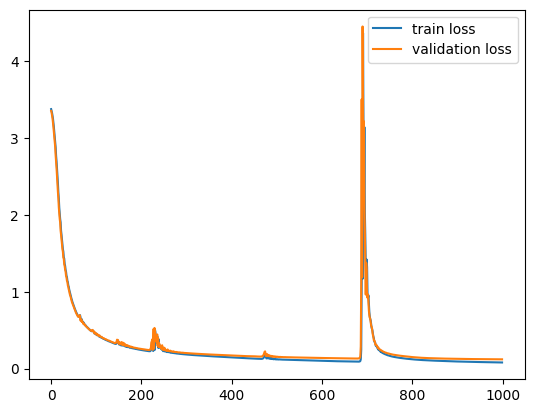


Testing...
Accuracy: 0.9769683985002678
Time taken for training in GPU: 4.780195951461792


In [23]:
print('Model for all signs:')
_, _, gpu_time = nn_train_test_pipeline(data_dict=data_dict, device=DEVICE)
print(f'Time taken for training in GPU: {gpu_time}')

Model for all signs:

Training...
Epoch     0 | Train loss:  3.3663 | Val loss:  3.3415
Epoch   100 | Train loss:  0.4484 | Val loss:  0.4130
Epoch   200 | Train loss:  0.2474 | Val loss:  0.2855
Epoch   300 | Train loss:  0.3459 | Val loss:  0.3443
Epoch   400 | Train loss:  0.1430 | Val loss:  0.1620
Epoch   500 | Train loss:  0.1146 | Val loss:  0.1396
Epoch   600 | Train loss:  0.0958 | Val loss:  0.1262
Epoch   700 | Train loss:  0.0815 | Val loss:  0.1172
Epoch   800 | Train loss:  0.0705 | Val loss:  0.1108
Epoch   900 | Train loss:  0.1216 | Val loss:  0.1464


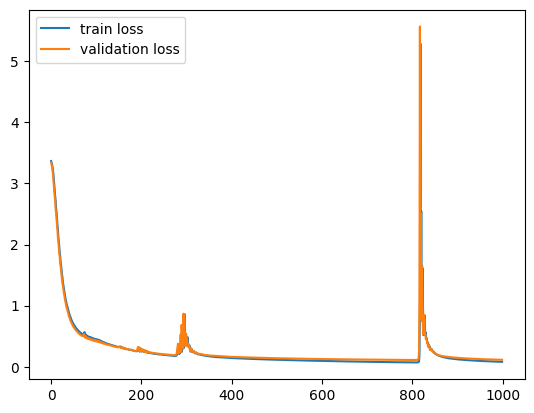


Testing...
Accuracy: 0.9783967148723443
Time taken for training in CPU: 10.017031192779541


In [24]:
print('Model for all signs:')
_, _, gpu_time = nn_train_test_pipeline(data_dict=data_dict, device=torch.device("cpu"))
print(f'Time taken for training in CPU: {gpu_time}')